In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

In [7]:
%matplotlib inline

import pandas as pd
from aeps import AEP_metrics_lims
from population import unit_response_matrix, activity_at_phase, pop_activity_phase_shifted
from session.sessions import selected_009266, selected_008229, selected_009265
from imports import *
from scipy import stats
from loading import load_session_data
from target import get_spike_counts
from statsmodels.formula.api import ols, glm
from sklearn.model_selection import train_test_split
from sklearn import decomposition

np.set_printoptions(suppress=True)

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [8]:
sessions = [s for s in selected_009266.keys()]
sessions.sort()
selected = sessions[:]
selected.remove('009266_hippoSIT_2023-04-20_15-24-14')  # only one A1 unit

# selected = [
#     '009265_hippoSIT_2023-03-09_20-03-08',
#     '009265_hippoSIT_2023-03-05_11-52-17'
# ]
selected = [
    "57_SIT_2023-12-21_15-05-52",
    "57_SIT_2023-12-22_14-08-07",
    "57_SIT_2023-12-22_17-37-18",
    "57_SIT_2023-12-28_16-43-28",
    "57_SIT_2023-12-29_11-06-26",
    "57_SIT_2023-12-29_11-40-14",
    "57_SIT_2024-01-02_16-38-05",
    "57_SIT_2024-01-02_17-10-09",
    "57_SIT_2024-01-03_19-54-59",
]
selected

['57_SIT_2023-12-21_15-05-52',
 '57_SIT_2023-12-22_14-08-07',
 '57_SIT_2023-12-22_17-37-18',
 '57_SIT_2023-12-28_16-43-28',
 '57_SIT_2023-12-29_11-06-26',
 '57_SIT_2023-12-29_11-40-14',
 '57_SIT_2024-01-02_16-38-05',
 '57_SIT_2024-01-02_17-10-09',
 '57_SIT_2024-01-03_19-54-59']

In [20]:
area = 'A1'
dst_path = "/home/sobolev/nevermind/AG_Pecka/data/processed/"
metric_names = list(AEP_metrics_lims[area].keys())

corrs1 = np.zeros([len(selected), len(metric_names), 160])
corrs2 = np.zeros([len(selected), len(metric_names), 160])
for i, session in enumerate(selected):
    animal   = session.split('_')[0]
    session_path = os.path.join(dst_path, animal, session)
    meta_file  = os.path.join(dst_path, animal, session, 'meta.h5')
    units_file = os.path.join(dst_path, animal, session, 'units.h5')

    with h5py.File(meta_file, 'r') as f:
        sound_events = np.array(f['processed']['sound_events'])
        tgt_mx       = np.array(f['processed']['target_matrix'])
        trials       = np.array(f['processed']['trial_idxs'])
        cfg          = json.loads(f['processed'].attrs['parameters'])
    
    # ---------------------------------------

    binning_mPFC_PCA = {
        50:  [8, 16, 65, 85],
        75:  [8, 16, 90, 110],
        100: [8, 16, 115, 135],
    }

    dur_bgr = int(cfg['sound']['sounds']['background']['duration'] * 1000)  # in ms
    dur_tgt = int(cfg['sound']['sounds']['target']['duration'] * 1000)  # in ms

    key_bgr = dur_bgr if dur_bgr in binning_mPFC_PCA else 50
    key_tgt = dur_tgt if dur_tgt in binning_mPFC_PCA else 50
    wx_m = pop_activity_phase_shifted(session_path, binning_mPFC_PCA[key_bgr], binning_mPFC_PCA[key_tgt], \
                                      do_pca=False, k_width=15)

    # ---------------------------------------
        
#     for j, (metric, window) in enumerate(AEP_metrics_lims[area].items()):
#         # TODO try target selective units only!
        
#         animal   = session.split('_')[0]
#         s_path = os.path.join(dst_path, animal, session)
#         times_to_event = AEP_metrics_lims['A1'].values()
#         bins, unit_mx = unit_response_matrix(s_path, [1, 2])#, times_to_event)
#         if j < 3:
#             resp_at_phase = unit_mx[j+1::5]
#         else:
#             resp_at_phase = unit_mx[j+1::5][:-1] + unit_mx[j+2::5]
            
#         # multiply by GLM profile for that session
#         #glm_file = os.path.join(source, animal, session, 'AEPs_pop.h5')
#         #with h5py.File(glm_file, 'r') as f:
#         #    glm_profile = np.array(f[metric]['glm_fit_params'])[1:]  # don't forget first is intercept
#         #unit_mx = unit_mx * glm_profile

#         # z-score
#         unit_act_matrix = resp_at_phase.T
#         for u, unit_data in enumerate(unit_act_matrix):
#             unit_act_matrix[u] = stats.zscore(unit_data)
#         resp_at_phase = unit_act_matrix.T
        
#         # simplest: raw sum of spike count
#         #pop_response = unit_mx[j+1::6].sum(axis=1)  # one way
#         pop_response1 = resp_at_phase.sum(axis=1)  # one way
        
#         # as a first PCA component
#         pca = decomposition.PCA(n_components=3)
#         pca.fit(resp_at_phase)
#         pop_response2 = pca.transform(resp_at_phase)[:, 0]

#         # as activity at phase
#         pop_response3 = activity_at_phase(session_path, phase=j+1, do_pca=True, k_width=15)
        

    for j in range(wx_m.shape[1]):
        pop_response = wx_m[:, j]
        
        # indices
        enter_all_idxs  = tgt_mx[:, 0]
        enter_miss_idxs = tgt_mx[tgt_mx[:, 4] == 0][:, 0]
        enter_succ_idxs = tgt_mx[tgt_mx[:, 4] == 1][:, 0]
        
        # filter short trials?
        trial_succ_idxs = np.where(trials[:, 5] == 1)[0]
        trial_succ_durs = (trials[trial_succ_idxs][:, 1] - trials[trial_succ_idxs][:, 0])/100
        idxs_filt = np.where(trial_succ_durs > 20)  # insert 20 to filter!
        
        tgt_enters_succ = np.zeros(len(pop_response))
        tgt_enters_succ[enter_succ_idxs] = 1
        tgt_enters_miss = np.zeros(len(pop_response))
        tgt_enters_miss[enter_miss_idxs] = 1

        corr1 = signal.correlate(pop_response, tgt_enters_succ)
        corr2 = signal.correlate(pop_response, tgt_enters_miss)
        idx_l, idx_r = int(len(corr1)/2) - 80, int(len(corr1)/2) + 80
        corrs1[i, j] = corr1[idx_l:idx_r]/len(enter_succ_idxs)
        corrs2[i, j] = corr2[idx_l:idx_r]/len(enter_miss_idxs)
    print(session)

57_SIT_2023-12-21_15-05-52
57_SIT_2023-12-22_14-08-07
57_SIT_2023-12-22_17-37-18
57_SIT_2023-12-28_16-43-28
57_SIT_2023-12-29_11-06-26
57_SIT_2023-12-29_11-40-14
57_SIT_2024-01-02_16-38-05
57_SIT_2024-01-02_17-10-09
57_SIT_2024-01-03_19-54-59


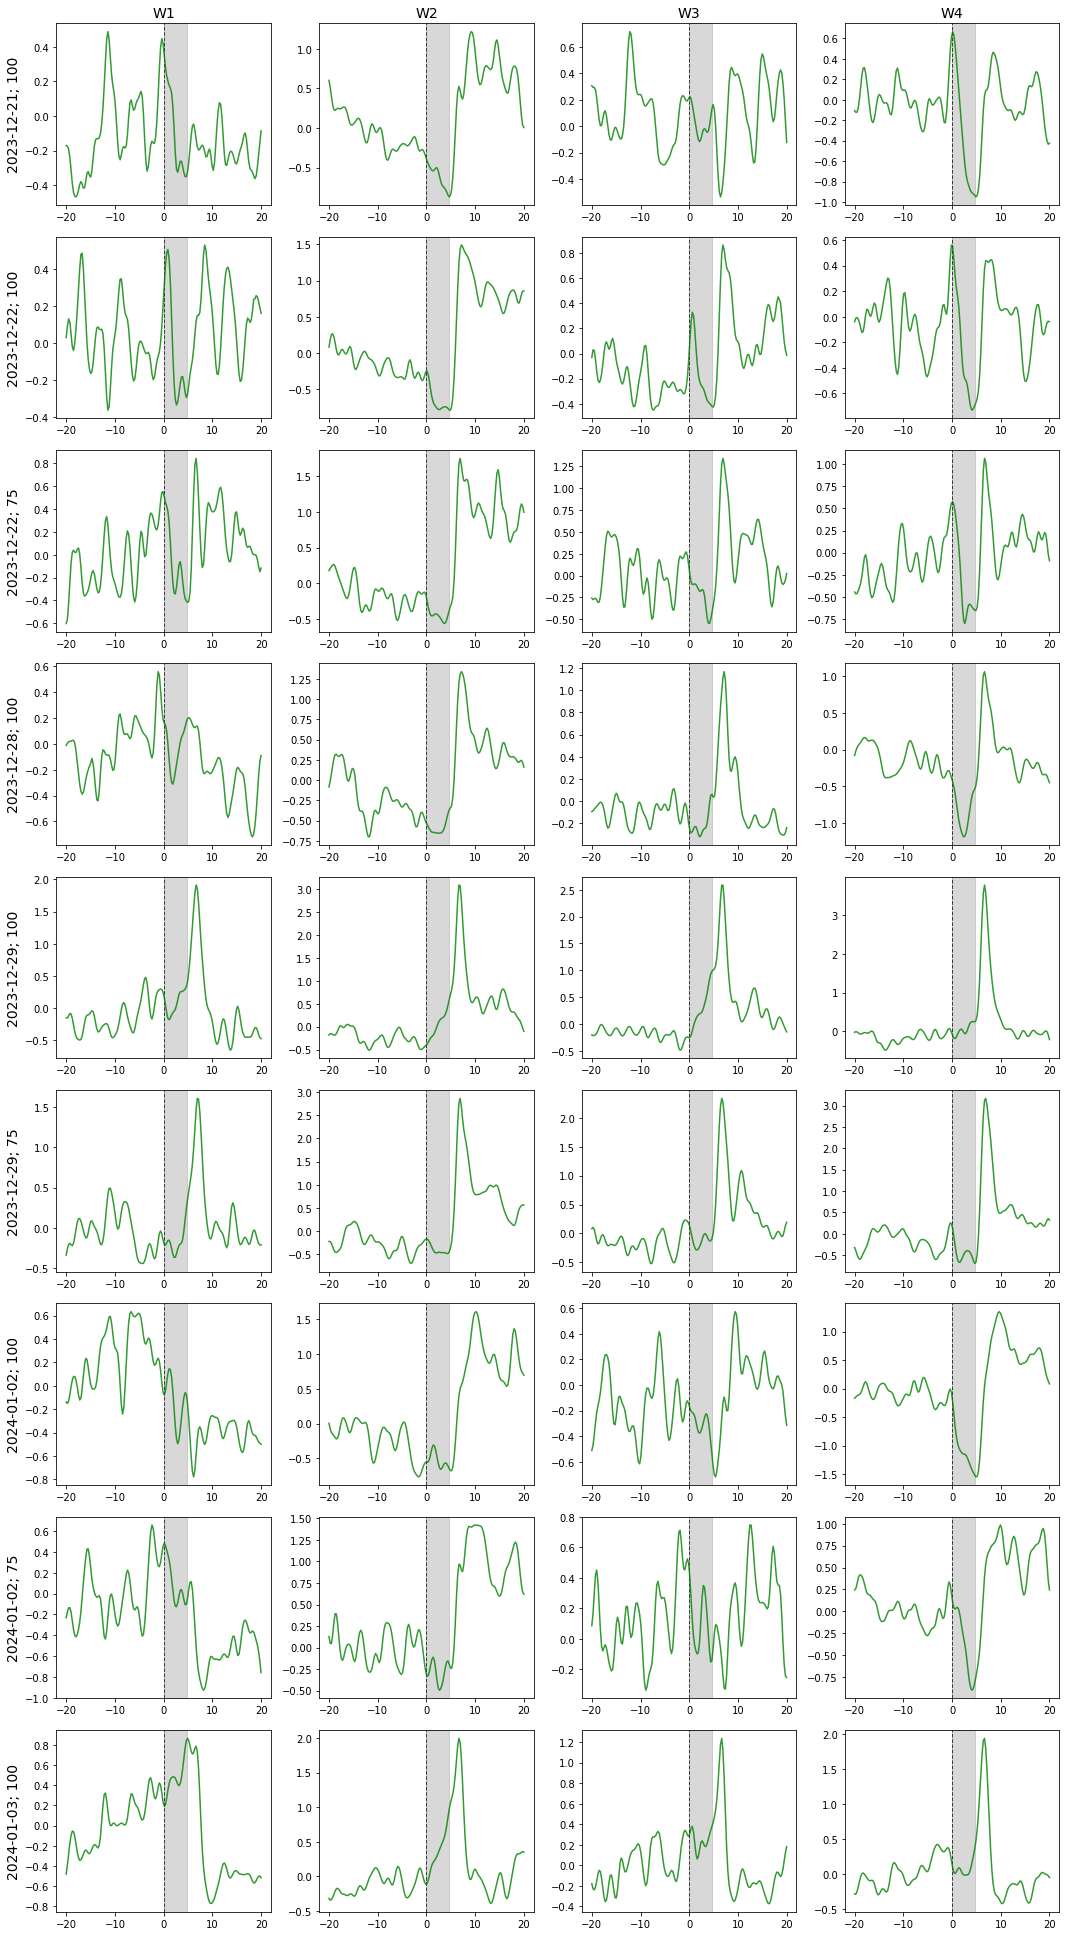

In [21]:
#selected = sessions[8:10]
fig, axes = plt.subplots(len(selected), len(metric_names), figsize=(15, 3*len(selected)))

for i, session in enumerate(selected):
    animal   = session.split('_')[0]
    session_path = os.path.join(dst_path, animal, session)
    meta_file  = os.path.join(dst_path, animal, session, 'meta.h5')
    with h5py.File(meta_file, 'r') as f:
        cfg          = json.loads(f['processed'].attrs['parameters'])
    tgt_dur = int(cfg['sound']['sounds']['target']['duration'] * 1000)
        
    for j, (metric, window) in enumerate(AEP_metrics_lims[area].items()):
        x_vals = np.linspace(-20, 20, 160)
        axes[i, j].axvline(0, color='black', ls='--', lw=1, alpha=0.7)
        axes[i, j].plot(x_vals, corrs1[i, j], color='green', alpha=0.8)
        #axes[i, j].plot(x_vals, corrs2[i, j], color='blue', alpha=0.8)
        axes[i, j].axvspan(0, 4.7, alpha=0.3, color='gray')
        if i == 0:
            #axes[i, j].set_title(metric_names[j])
            axes[i, j].set_title("W%s" % str(j+1), fontsize=14)
        if j == 0:
            axes[i, j].set_ylabel('%s; %d' % (session[-19:-9], tgt_dur), fontsize=14)
            
fig.tight_layout()
rep_path = '/home/sobolev/nevermind/Andrey/analysis/reporting'
#fig.savefig(os.path.join(rep_path, '%s_%s_CCR_pop_resp_tgt_enters_succ_ALL.pdf' % (animal, area)))
#fig.savefig(os.path.join(rep_path, '%s_CCR_pop_resp_tgt_enters_succ.png' % session), dpi=1000)

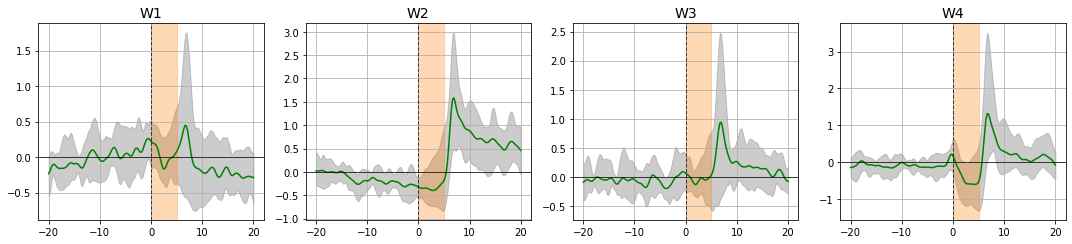

In [22]:
fig, axes = plt.subplots(1, len(metric_names), figsize=(15, 3.5))
#session_idxs = np.concatenate([np.arange(0, 4), np.arange(7, 15)])
#corrs_filt = corrs1[session_idxs]
corrs_filt = corrs1

for i in range(len(metric_names)):
    # percentiles
    confidence_low  = np.zeros(160)
    confidence_high = np.zeros(160)
    for j, col in enumerate(corrs_filt[:, i].T):
        confidence_low[j]  = np.percentile(col, 5)
        confidence_high[j] = np.percentile(col, 95)

    x_vals = np.linspace(-20, 20, 160)
    axes[i].plot(x_vals, corrs_filt[:, i].mean(axis=0), color='green')
    #axes[i].plot(x_vals, corrs2[session_idxs][:, i].mean(axis=0), color='red')
    axes[i].fill_between(x_vals, confidence_low, confidence_high, color='gray', alpha=0.4)
    axes[i].axvline(0, color='black', ls='--', lw=1, alpha=0.7)
    axes[i].axhline(0, color='black', lw=1, alpha=0.7)
    axes[i].grid()
    axes[i].axvspan(0, 5, alpha=0.3, color='tab:orange')
    axes[i].set_title("W%s" % str(i+1), fontsize=14)
    
fig.tight_layout()
#fig.savefig(os.path.join(rep_path, '%s_%s_CCR_pop_resp_tgt_enters_succ_AVG.png' % (animal, area)), dpi=1000)

## Succ / miss

In [529]:
# Increased N1-P3 FR and decreased P1 FR AFTER the successful target (no sound) 
# implies top-down control of late response, bottom up of P1

## Single session - progression

In [41]:
dst_path = "/home/sobolev/nevermind/AG_Pecka/data/processed/"
session  = sessions[0]
animal   = session.split('_')[0]
meta_file  = os.path.join(dst_path, animal, session, 'meta.h5')
units_file = os.path.join(dst_path, animal, session, 'units.h5')
psth_file = os.path.join(dst_path, animal, session, 'analysis', 'psth.h5')

with h5py.File(meta_file, 'r') as f:
    sound_events = np.array(f['processed']['sound_events'])
    #trials       = np.array(f['processed']['trial_idxs'])
    #cfg          = json.loads(f['processed'].attrs['parameters'])
    tgt_mx       = np.array(f['processed']['target_matrix'])
    tl           = np.array(f['processed']['timeline'])
    
# load units
unit_names, single_units, spike_times = [], {}, {}
with h5py.File(units_file, 'r') as f:
    unit_names = [x for x in f]

with h5py.File(units_file, 'r') as f:
    for unit_name in unit_names:
        spike_times[unit_name]  = np.array(f[unit_name][H5NAMES.spike_times['name']])
        single_units[unit_name] = np.array(f[unit_name][H5NAMES.inst_rate['name']])

In [42]:
# 0.03 - 0.08 give a nice CCR
unit_mx = unit_response_matrix(session, 'A1', 0.1, 0.2)
unit_mx.shape

(9599, 16)

In [46]:
pop_response = unit_mx.sum(axis=1)

enter_all_idxs  = tgt_mx[:, 0]
enter_miss_idxs = tgt_mx[tgt_mx[:, 4] == 0][:, 0]
enter_succ_idxs = tgt_mx[tgt_mx[:, 4] == 1][:, 0]

tgt_enters = np.zeros(len(pop_response))
tgt_enters[enter_succ_idxs] = 1

tgt_on = np.zeros(len(sound_events))
tgt_on[sound_events[:, 1] == 2] = 1

In [66]:
hw = 80
iter_count = 1000
idxs = enter_all_idxs
idxs = idxs[idxs > hw]
idxs = idxs[idxs < len(pop_response) - hw]
boot_means = np.zeros([iter_count, 2*hw])

for j in range(iter_count):
    boot_idxs = np.random.choice(idxs, size=len(idxs))
    psth = np.zeros([len(boot_idxs), 2*hw])
    for i, pulse_idx in enumerate(boot_idxs):
        psth[i] = pop_response[pulse_idx - hw:pulse_idx + hw]
    boot_means[j] = psth.mean(axis=0)

# percentiles
confidence_5_0_low  = np.zeros(boot_means.shape[1])
confidence_2_5_low  = np.zeros(boot_means.shape[1])
confidence_95_0_high = np.zeros(boot_means.shape[1])
confidence_97_5_high = np.zeros(boot_means.shape[1])
for i, col in enumerate(boot_means.T):
    confidence_5_0_low[i]  = np.percentile(col, 5)
    confidence_95_0_high[i] = np.percentile(col, 95)
    confidence_2_5_low[i]  = np.percentile(col, 2.5)
    confidence_97_5_high[i] = np.percentile(col, 97.5)

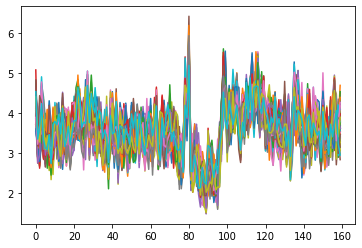

In [67]:
for bm in boot_means[:100]:
    plt.plot(bm)

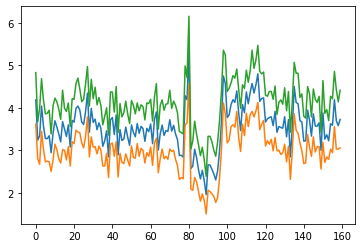

In [71]:
plt.plot(boot_means.mean(axis=0))
plt.plot(confidence_2_5_low)
plt.plot(confidence_97_5_high)

## compute same as CCR

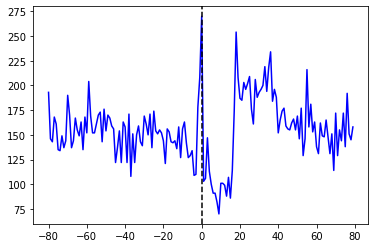

In [54]:
corr = signal.correlate(pop_response, tgt_enters)
lags = signal.correlation_lags(len(tgt_enters), len(pop_response))

idx_l, idx_r = int(len(lags)/2) - 20*4, int(len(lags)/2) + 20*4
plt.plot(lags[idx_l:idx_r], corr[idx_l:idx_r], color='blue')
plt.axvline(0, color='black', ls='--')

(1000.0, 2000.0)

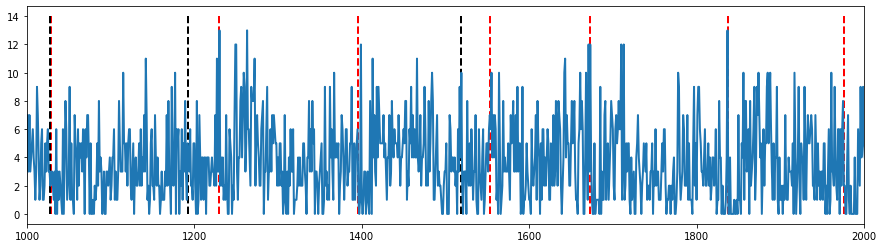

In [560]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))

ax.plot(pop_response, color='tab:blue', lw=2)
ax.vlines(x=enter_succ_idxs, ymin=0, ymax=pop_response.max(), color='red', lw=2, ls='--')
ax.vlines(x=enter_miss_idxs, ymin=0, ymax=pop_response.max(), color='black', lw=2, ls='--')
ax.set_xlim(1000, 2000)

<BarContainer object of 62 artists>

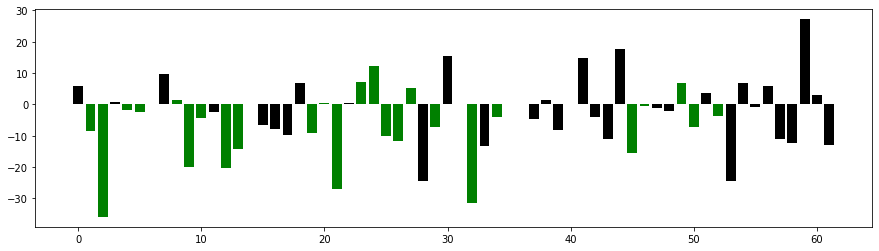

In [500]:
fig, ax = plt.subplots(1, 1, figsize=(15, 4))

colors = ['green' if r == 1 else 'black' for r in tgt_mx[:, 4]]
ax.bar(np.arange(len(tgt_mx)), pop_response[tgt_mx[:, 0]] - pop_response[tgt_mx[:, 0]-1], color=colors)

## Pop response + MMR succ / miss across sessions

In [94]:
area = 'A1'
dst_path = "/home/sobolev/nevermind/AG_Pecka/data/processed/"
selected = sessions[:]
titles = ['P1', 'N1', 'P2', 'P3']

pop_resp_succ = dict([(i, np.zeros(0)) for i in range(4)])
pop_resp_miss = dict([(i, np.zeros(0)) for i in range(4)])
for i, session in enumerate(selected):
    animal   = session.split('_')[0]
    meta_file  = os.path.join(dst_path, animal, session, 'meta.h5')
    units_file = os.path.join(dst_path, animal, session, 'units.h5')

    with h5py.File(meta_file, 'r') as f:
        sound_events = np.array(f['processed']['sound_events'])
        tgt_mx       = np.array(f['processed']['target_matrix'])
    
    for j, window in enumerate([(0.01, 0.03), (0.03, 0.075), (0.075, 0.1), (0.1, 0.2)]):
        pop_response = unit_response_matrix(session, area, window[0], window[1]).sum(axis=1)

        enter_all_idxs  = tgt_mx[:, 0]
        enter_miss_idxs = tgt_mx[tgt_mx[:, 4] == 0][:, 0]
        enter_succ_idxs = tgt_mx[tgt_mx[:, 4] == 1][:, 0]

        pop_resp_succ[j] = np.concatenate([pop_resp_succ[j], pop_response[enter_all_idxs + 2]])
        pop_resp_miss[j] = np.concatenate([pop_resp_miss[j], pop_response[enter_all_idxs - 1]])

    print(session)

009266_hippoSIT_2023-04-17_17-04-17
009266_hippoSIT_2023-04-18_10-10-37
009266_hippoSIT_2023-04-18_17-03-10
009266_hippoSIT_2023-04-19_10-33-51
009266_hippoSIT_2023-04-20_08-57-39
009266_hippoSIT_2023-04-20_15-24-14
009266_hippoSIT_2023-04-21_08-43-00
009266_hippoSIT_2023-04-21_13-12-31
009266_hippoSIT_2023-04-24_10-08-11
009266_hippoSIT_2023-04-24_16-56-55
009266_hippoSIT_2023-04-26_08-20-17
009266_hippoSIT_2023-05-02_12-22-14
009266_hippoSIT_2023-05-04_19-47-15
009266_hippoSIT_2023-05-22_09-27-22
009266_hippoSIT_2023-05-23_09-18-05
009266_hippoSIT_2023-05-25_15-55-57
009266_hippoSIT_2023-06-14_08-21-23
009266_hippoSIT_2023-06-19_08-58-35


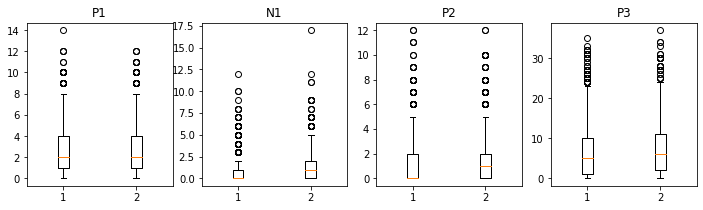

In [95]:
fig, axes = plt.subplots(1, 4, figsize=(12, 3))

for i in range(4):
    axes[i].boxplot([pop_resp_succ[i], pop_resp_miss[i]])
    axes[i].set_title(titles[i])

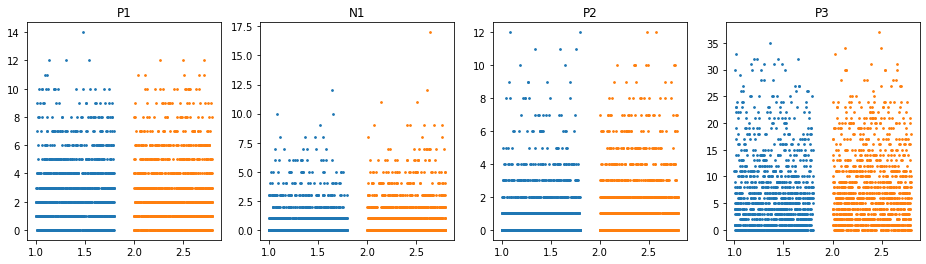

In [96]:
fig, axes = plt.subplots(1, 4, figsize=(16, 4))

for i in range(4):
    axes[i].scatter(0.8*np.random.rand(len(pop_resp_succ[i])) + 1, pop_resp_succ[i], s=3)
    axes[i].scatter(0.8*np.random.rand(len(pop_resp_miss[i])) + 2, pop_resp_miss[i], s=3)
    axes[i].set_title(titles[i])

In [561]:
MMR = pop_response[tgt_mx[:, 0]] - pop_response[tgt_mx[:, 0]-1]

MMR[tgt_mx[:, 4] == 1].mean(), MMR[tgt_mx[:, 4] == 0].mean()

(1.3777777777777778, 0.5185185185185185)

In [100]:
s_start, s_end = tl[0][0], tl[-1][0]

np.arange(s_start, s_end, 1./100)

array([   0.  ,    0.01,    0.02, ..., 2399.94, 2399.95, 2399.96])